# Problem 2

This is the same problem of the Homework 3, but with the addition that we want to tackle the big data challenge!

The data is a sample of the entire data from the [Click-Through Rate Prediction](https://www.kaggle.com/c/avazu-ctr-prediction/data). You will explore using Logistic Regression and SVM for this problem.

Data fields
- id: ad identifier
- click: 0/1 for non-click/click
- hour: format is YYMMDDHH, so 14091123 means 23:00 on Sept. 11, 2014 UTC.
- C1 -- anonymized categorical variable
- banner_pos
- site_id
- site_domain
- site_category
- app_id
- app_domain
- app_category
- device_id
- device_ip
- device_model
- device_type
- device_conn_type
- C14-C21 -- anonymized categorical variables

The input variables are 'hour' up to 'C21', however, we will not use all of them.
The output variable is 'click', which is a binary variable.



In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, date, time
from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.feature_extraction import FeatureHasher
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import log_loss
import scipy as sp
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt 
%matplotlib inline

### Part 0: Feature Hashing
In the last example, we have demonstrate the use of `get_dummy`, we will use the `FeatureHasher` in this example, which is easier to handle the problem of inconsistent train and test categorical, which is a big problem in online learning.

Let's first read the Testing Data! We will only load the first 10000 lines for illustration


In [2]:
data_test = pd.read_csv("clrtest")
data_test = data_test.head(10000)
fh = FeatureHasher(n_features = 2**20, input_type="string")

y_test = data_test["click"]
X_test = fh.transform(np.asarray(data_test.iloc[:,4:].astype(str)))        


In [3]:
X_test.shape

(9999, 1048576)

### Read the training data with chunksize 
Please specify the reading from the pd.read_csv with chunksize to handle the big data. You need to define a reasonable chuck size by yourself

In [4]:
tp = pd.read_csv("clrtrain", iterator=True, chunksize=1000)
data_train = pd.concat(tp, ignore_index=True)

In [5]:
data_train.shape

(2999999, 25)

### Defining Classifiers
Please define two or (three) classifiers
- `SGDClassifier` with `hinge` loss with L1 penalty (SVM with L1), you can choose a constant learning rate. You can choose the class_weight to balance the 0 and 1 class. For example, by setting `class_weight={0:1,1:4}` 
-  `SGDClassifier` with `log` loss with L1 penalty (Logistic Regression with L1), you can choose a constant learning rate. You can choose the class_weight to balance the 0 and 1 class. For example, by setting `class_weight={0:1,1:4}`

- `sklearn.naive_bayes.BernoulliNB` also support `partial-fit`, which can be applied. 

In [6]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import BernoulliNB

clf1= SGDClassifier(loss='hinge', penalty='l1', learning_rate='constant', class_weight={0:1,1:4}, n_jobs=-1, random_state=10, eta0=0.01)
clf2 = SGDClassifier(loss='log', penalty='l1', learning_rate='constant', class_weight={0:1,1:4}, n_jobs=-1, random_state=10, eta0=0.01)
clf3 = BernoulliNB()

In [7]:
data_train["click"].value_counts()

0    2500667
1     499332
Name: click, dtype: int64

### Starting Training
Please start training, we will use the same technique that covered in the class. We will read the chunk of data as in `data_train`. We can use `partial_fit` to update the results of `clf1`, `clf2`, `clf3`. Please monitoring the `auc` of both training and testing over the number of samples you have seen. Similar to the learning curve we have shown in the class, but with AUC instead of error as y-axis.


In [29]:
from sklearn.metrics import f1_score
from sklearn import metrics

chunksize = 100000
trainloss = []
testloss = []

for i,chunk in enumerate(pd.read_csv('clrtrain', chunksize=chunksize)):
    X_train = fh.transform(np.asarray(chunk.iloc[:,4:].astype(str)))
    y_train = chunk.iloc[:,2]    
    clf1.partial_fit(X_train,y_train,classes=[0,1])
    trainloss.append(f1_score(y_train,clf1.predict(X_train)))
    testloss.append(f1_score(y_test,clf1.predict(X_test)))

In [35]:
Training_F1_score = ['%.3f' % elem for elem in trainloss]
print("Training F1 Score:", Training_F1_score,'\n')
Testing_F1_score = ['%.3f' % elem for elem in testloss]
print("Testing F1 Score:",Testing_F1_score)

Training F1 Score: ['0.403', '0.394', '0.393', '0.405', '0.401', '0.400', '0.385', '0.416', '0.397', '0.337', '0.408', '0.368', '0.380', '0.392', '0.400', '0.402', '0.386', '0.403', '0.400', '0.398', '0.412', '0.395', '0.381', '0.379', '0.406', '0.412', '0.407', '0.410', '0.395', '0.400'] 

Testing F1 Score: ['0.387', '0.379', '0.384', '0.389', '0.390', '0.377', '0.376', '0.399', '0.377', '0.326', '0.389', '0.369', '0.372', '0.353', '0.380', '0.379', '0.352', '0.390', '0.384', '0.374', '0.390', '0.379', '0.361', '0.362', '0.377', '0.382', '0.387', '0.377', '0.383', '0.385']


In [21]:
print("Mean training F1_score for loop:",format(np.mean(trainloss), '.3f'))
print("Mean testing F1_score for loop:",format(np.mean(testloss), '.3f'))

Mean training F1_score for loop: 0.396
Mean testing F1_score for loop: 0.378


In [10]:
trainloss1 = []
testloss1 = []

for i,chunk in enumerate(pd.read_csv('clrtrain', chunksize=chunksize)):
    X_train = fh.transform(np.asarray(chunk.iloc[:,4:].astype(str)))
    y_train = chunk.iloc[:,2]    
    clf2.partial_fit(X_train,y_train,classes=[0,1])
    fpr, tpr, thresholds = metrics.roc_curve(y_train,clf2.predict(X_train))
    trainloss1.append(metrics.auc(fpr, tpr))
    fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test,clf2.predict(X_test))
    testloss1.append(metrics.auc(fpr_t, tpr_t))
    

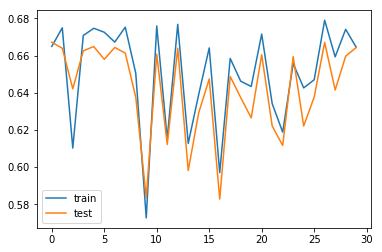

In [11]:
plt.plot(trainloss1)
plt.plot(testloss1)
plt.legend(('train','test'))
plt.show()

In [12]:
trainloss2 = []
testloss2 = []

for i,chunk in enumerate(pd.read_csv('clrtrain', chunksize=chunksize)):
    X_train = fh.transform(np.asarray(chunk.iloc[:,4:].astype(str)))
    y_train = chunk.iloc[:,2]    
    clf3.partial_fit(X_train,y_train,classes=[0,1])
    fpr, tpr, thresholds = metrics.roc_curve(y_train,clf3.predict(X_train))
    trainloss2.append(metrics.auc(fpr, tpr))
    fpr_t, tpr_t, thresholds_t = metrics.roc_curve(y_test,clf3.predict(X_test))
    testloss2.append(metrics.auc(fpr_t, tpr_t))
    

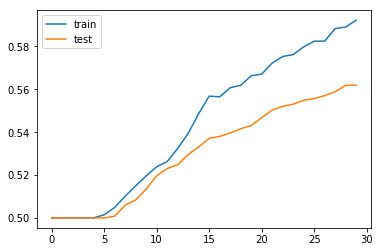

In [13]:
plt.plot(trainloss2)
plt.plot(testloss2)
plt.legend(('train','test'))
plt.show()